In [ ]:
!pip install ultralytics opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [11]:
# -------------------------------
# SETTINGS
# -------------------------------
DATA_YAML = "/content/drive/MyDrive/CF-MADRL-YOLO/dataset_custom.yaml"
BASE_MODEL = "yolo26n.pt"
VIDEO_PATH = "/content/drive/MyDrive/CF-MADRL-YOLO/traffic_jam.mp4"
OUTPUT_PATH = "/content/drive/MyDrive/CF-MADRL-YOLO/output_fixed.mp4"
CUSTOM_MODEL_PATH = "runs/detect/custom_yolo26/weights/best.pt"

TRAIN_EPOCHS = 50

IMG_SIZE = 640
PIXEL_TO_METER = 0.05
STOP_SPEED_KMH = 3.0
VEHICLE_CLASSES = [1, 2, 3, 5, 7] # car, motorcycle, bus, truck

In [12]:
# Train using YOLO26 base
train_model = YOLO(BASE_MODEL)

# train_model.train(
#     data=DATA_YAML,
#     epochs=TRAIN_EPOCHS,
#     imgsz=IMG_SIZE,
#     batch=8,
#     workers=2,
#     name="custom_yolo26"
# )


In [13]:
# -------------------------------
# INITIALIZE
# -------------------------------
custom_model = YOLO(CUSTOM_MODEL_PATH)
fallback_model = YOLO(BASE_MODEL)

cap = cv2.VideoCapture(VIDEO_PATH)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

# ROI Definitions
ROI_Y_MIN, ROI_Y_MAX = int(height * 0.4), int(height * 0.9)
ROI_X_MIN, ROI_X_MAX = int(width * 0.1), int(width * 0.9)

# Trackers
vehicle_tracks = {}
prev_gray = None

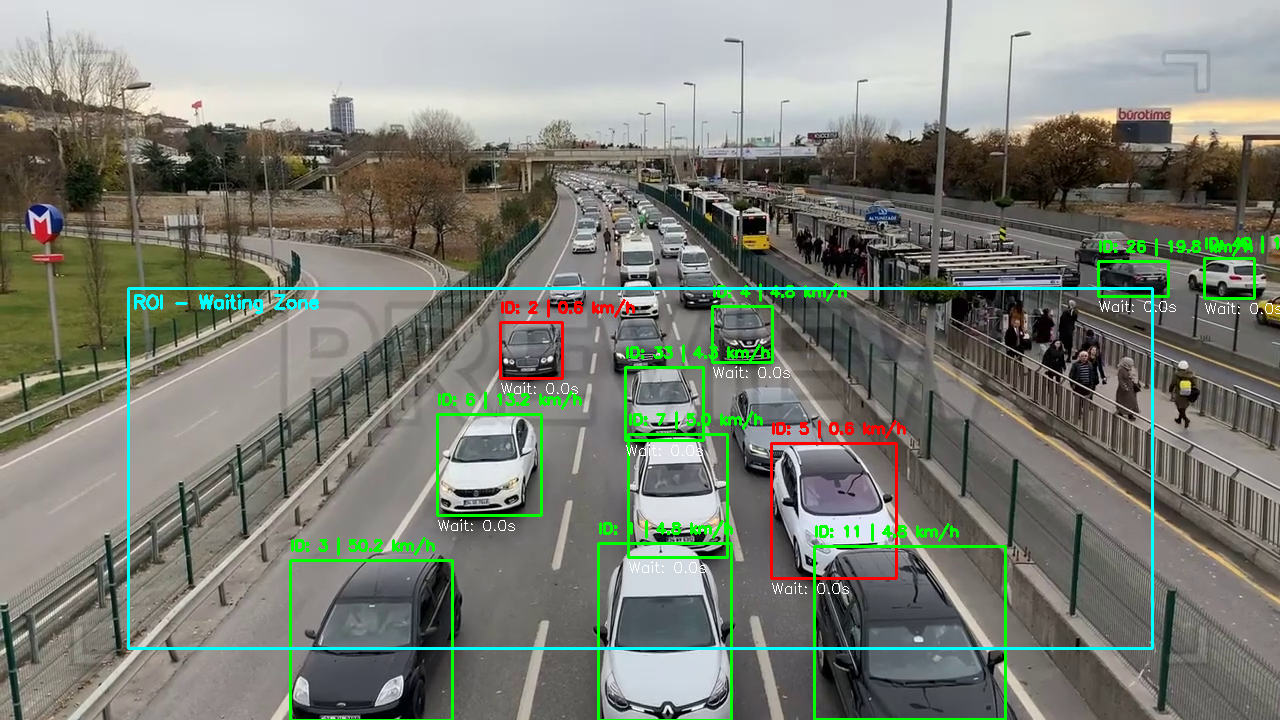

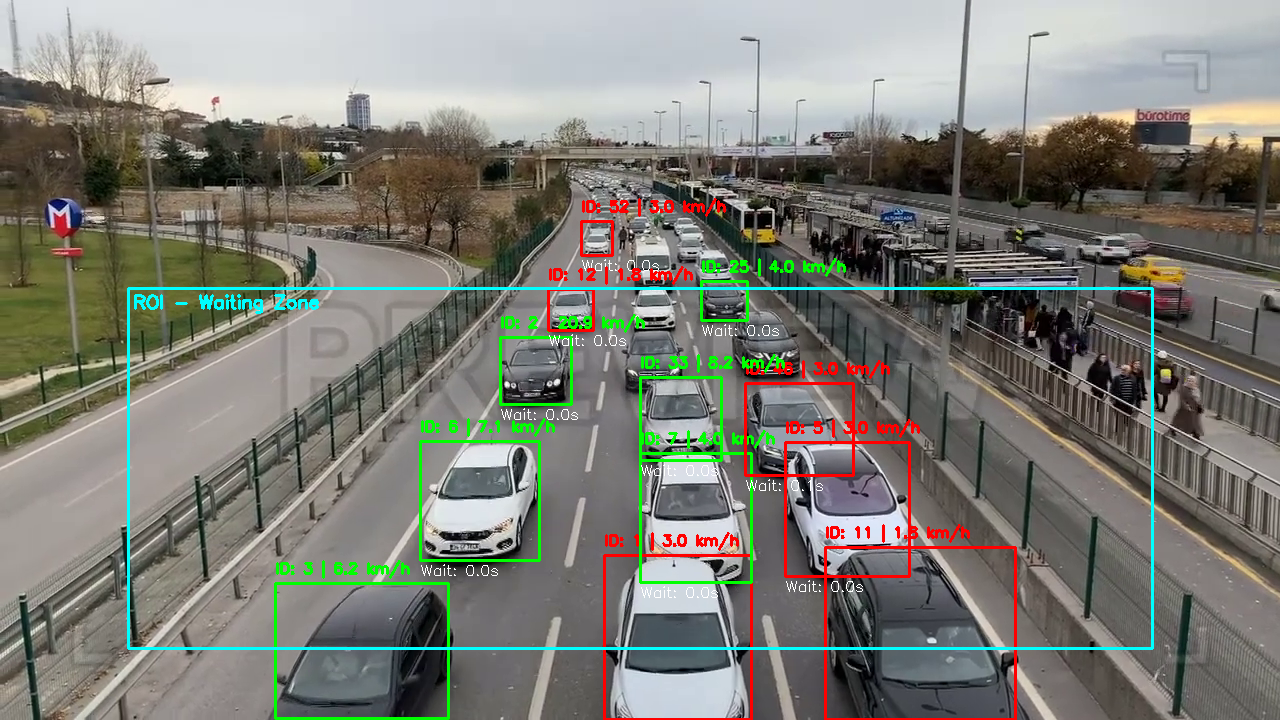

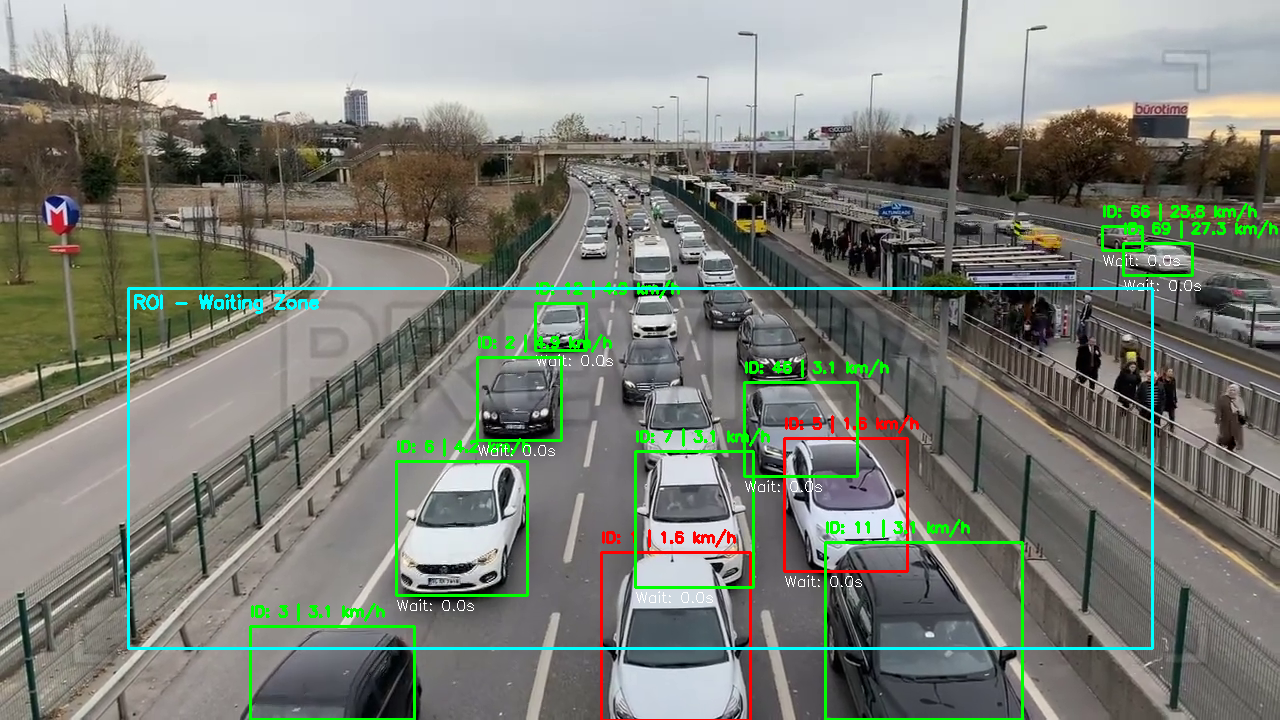

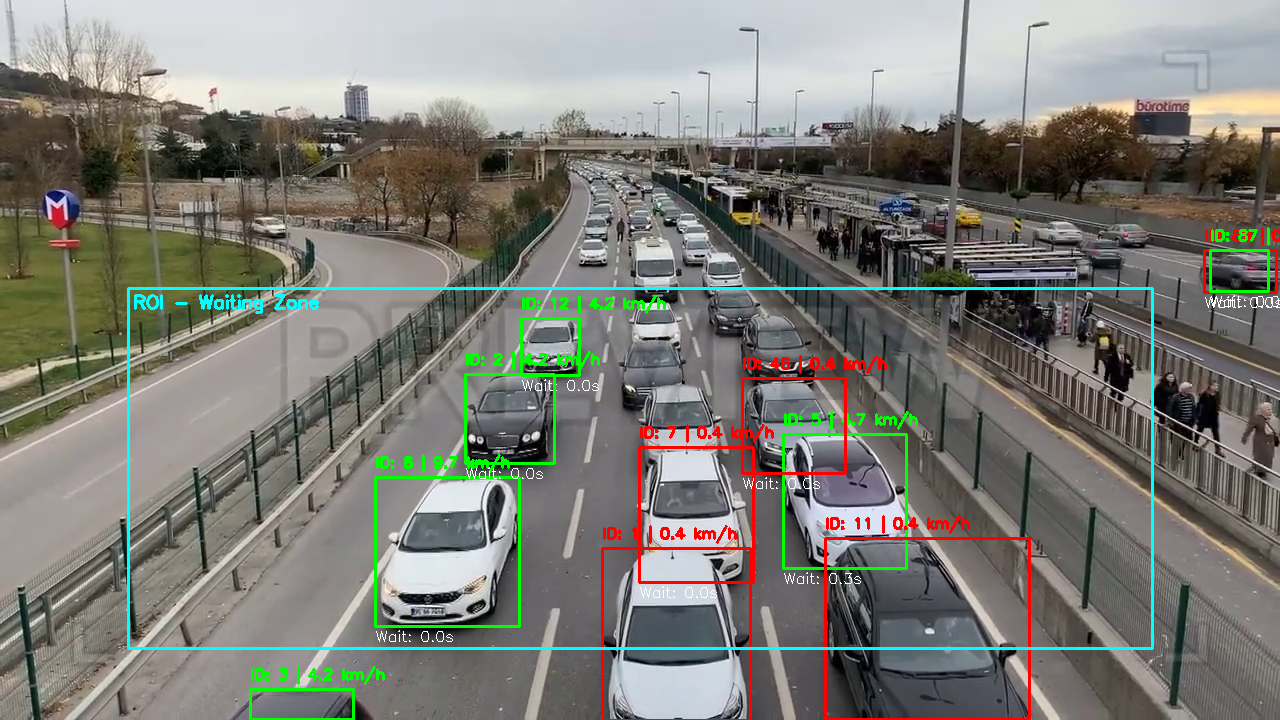

In [ ]:
# -------------------------------
# MAIN LOOP
# -------------------------------
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break

    frame_count += 1
    current_time_s = frame_count / fps
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1. CAMERA MOTION ESTIMATION (GMC)
    # We track movement of static background to subtract it from vehicle movement
    camera_dx, camera_dy = 0, 0
    if prev_gray is not None:
        # Track 10 points in the corners (likely background) to see if camera moved
        pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=10, qualityLevel=0.3, minDistance=7)
        if pts is not None:
            next_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, gray, pts, None)
            good_new = next_pts[status == 1]
            good_old = pts[status == 1]
            if len(good_new) > 0:
                camera_dx = np.mean(good_new[:, 0] - good_old[:, 0])
                camera_dy = np.mean(good_new[:, 1] - good_old[:, 1])

    prev_gray = gray.copy()

    # 2. RUN TRACKING
    results = custom_model.track(frame, persist=True, tracker="bytetrack.yaml", conf=0.3, verbose=False)

    # Fallback if custom model fails to find anything
    # Fallback if custom model finds no boxes
    if not results[0].boxes or len(results[0].boxes) == 0:
        results = fallback_model.track(frame, persist=True, tracker="bytetrack.yaml", conf=0.3, verbose=False)

    # 3. PROCESS DETECTIONS
    if results[0].boxes.id is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id.cpu().numpy().astype(int)
        clss = results[0].boxes.cls.cpu().numpy().astype(int)

        for box, tid, cls in zip(boxes, ids, clss):
            if cls not in VEHICLE_CLASSES: continue

            x1, y1, x2, y2 = box
            cx, cy = int((x1 + x2) / 2), int(y2) # Bottom center

            # Initialize track
            if tid not in vehicle_tracks:
                vehicle_tracks[tid] = {
                    "pos": (cx, cy),
                    "wait_start": None,
                    "total_wait": 0.0,
                    "last_seen": current_time_s
                }

            track = vehicle_tracks[tid]
            prev_cx, prev_cy = track["pos"]

            # 4. CALCULATE REAL MOVEMENT (Subtracting Camera Movement)
            # dx_real = (current_x - previous_x) - camera_offset
            dx = (cx - prev_cx) - camera_dx
            dy = (cy - prev_cy) - camera_dy
            dist_px = np.hypot(dx, dy)

            # Speed in km/h: (meters per sec) * 3.6
            speed_kmh = (dist_px * PIXEL_TO_METER * fps) * 3.6

            # 5. WAITING TIME LOGIC
            inside_roi = (ROI_Y_MIN < cy < ROI_Y_MAX) and (ROI_X_MIN < cx < ROI_X_MAX)

            if inside_roi and speed_kmh < STOP_SPEED_KMH:
                if track["wait_start"] is None:
                    track["wait_start"] = current_time_s
                track["total_wait"] = current_time_s - track["wait_start"]
            else:
                track["wait_start"] = None # Reset if they move

            # Update track state
            track["pos"] = (cx, cy)
            track["last_seen"] = current_time_s

            # 6. DRAWING
            color = (0, 255, 0) if speed_kmh > STOP_SPEED_KMH else (0, 0, 255)
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(frame, f"ID: {tid} | {speed_kmh:.1f} km/h", (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.putText(frame, f"Wait: {track['total_wait']:.1f}s", (int(x1), int(y2) + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # UI Overlay
    cv2.rectangle(frame, (ROI_X_MIN, ROI_Y_MIN), (ROI_X_MAX, ROI_Y_MAX), (255, 255, 0), 2)
    cv2.putText(frame, f"ROI - Waiting Zone", (ROI_X_MIN + 5, ROI_Y_MIN + 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    out.write(frame)
    # Optional: Display every 10th frame to save Colab resources
    if frame_count % 30 == 0:
        cv2_imshow(frame)

cap.release()
out.release()
print(f"Processing Complete. File saved to: {OUTPUT_PATH}")